In [44]:
print('startt')

startt


In [45]:
import pandas as pd
import numpy as np

In [46]:
data = pd.read_excel('Data/deposit.xlsx', parse_dates=True, index_col='year')

In [47]:
data.head()

,deposit
year,
1980-01-01,0.0825
1981-01-01,0.1200
1982-01-01,0.1200
1983-01-01,0.1200
1984-01-01,0.1200


In [48]:
import matplotlib.pyplot as plt

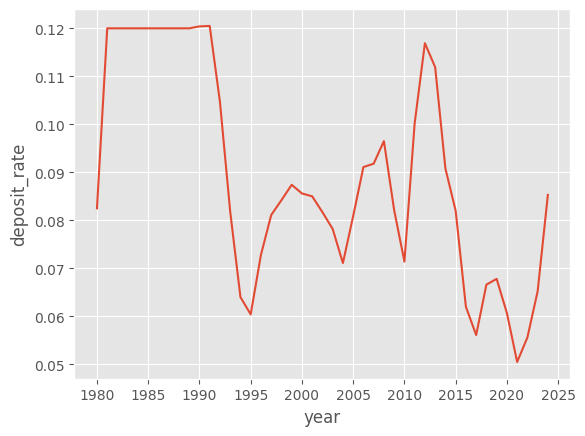

In [49]:
plt.style.use('ggplot')
plt.plot(data.index, data.deposit)
plt.xlabel('year')
plt.ylabel('deposit_rate')
plt.show()

In [50]:
from statsmodels.tsa.stattools import adfuller

In [51]:
adf = adfuller(data.deposit)
print(adf[1])

0.033845594088384924


In [52]:
# data_diff = data.diff().dropna()
# plt.plot(data_diff.index, data_diff.deposit)

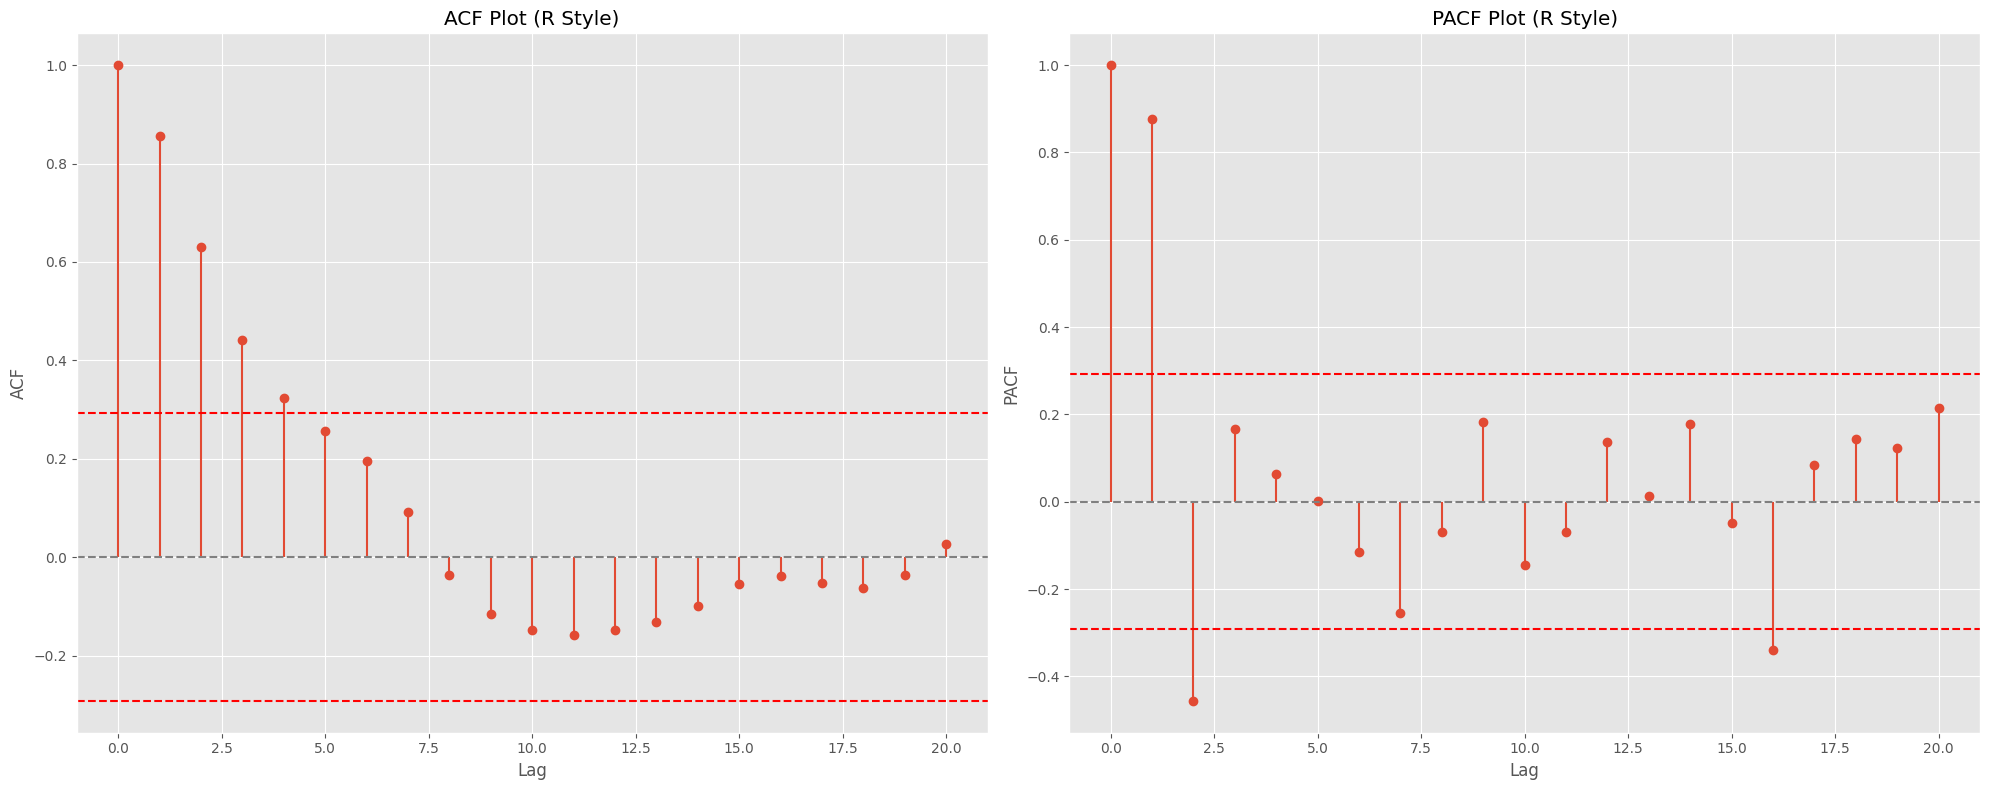

In [53]:
from statsmodels.graphics.tsaplots import acf, pacf
# Compute ACF and PACF values
acf_values = acf(data['deposit'], nlags=20)
pacf_values = pacf(data['deposit'], nlags=20)

# Generate lags for x-axis
lags = np.arange(len(acf_values))

# Plot ACF with lines
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.stem(lags, acf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data['deposit'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data['deposit'])), linestyle='--', color='red')
plt.title('ACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('ACF')

# Plot PACF with lines
plt.subplot(122)
plt.stem(lags, pacf_values, basefmt=" ")
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(data['deposit'])), linestyle='--', color='red')
plt.axhline(y=-1.96 / np.sqrt(len(data['deposit'])), linestyle='--', color='red')
plt.title('PACF Plot (R Style)')
plt.xlabel('Lag')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()


The correlogram shows that the data can be modeled with AR(2) process, since ACF is decaying while the PACF cuts off at lag 2.

## Modeling

In [54]:
from statsmodels.tsa.arima.model import ARIMA

In [55]:
model = ARIMA(data, order=(2, 0, 0))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [56]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                deposit   No. Observations:                   45
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 142.811
Date:                Sat, 10 May 2025   AIC                           -277.623
Time:                        11:59:26   BIC                           -270.396
Sample:                    01-01-1980   HQIC                          -274.928
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0883      0.008     11.446      0.000       0.073       0.103
ar.L1          1.3271      0.111     11.957      0.000       1.110       1.545
ar.L2         -0.5525      0.112     -4.928      0.0

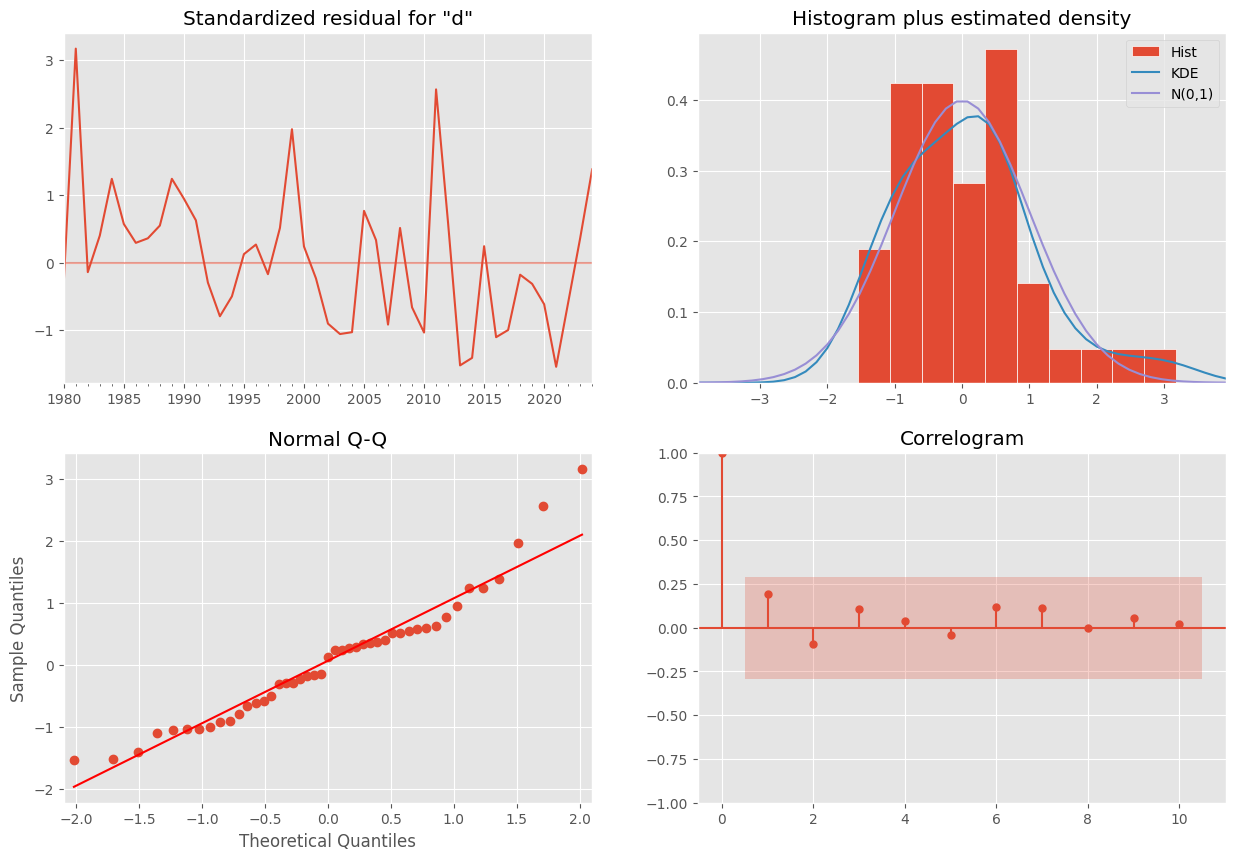

In [82]:
fig = results.plot_diagnostics(figsize=(15, 10))
plt.show()

The Jarque-Bera test shows that the residuals are not normally distributed. Box-Cox transformation may improve the model.

In [90]:
from scipy.stats import boxcox
import seaborn as sns

Optimal Lambda: 0.40284512020891317


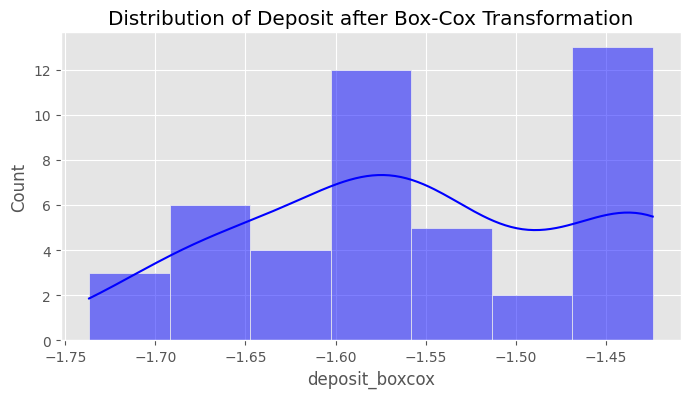

In [91]:
data['deposit_boxcox'], lam = boxcox(data['deposit'])
print(f"Optimal Lambda: {lam}")

# Plot the distribution of transformed data
plt.figure(figsize=(8, 4))
sns.histplot(data['deposit_boxcox'], kde=True, color='blue')
plt.title('Distribution of Deposit after Box-Cox Transformation')
plt.show()

In [87]:
# testing for residuals so that they are white noise
adf_res = adfuller(results.resid)
print(adf_res[1])

1.9248529258149736e-05


In [74]:
# Fitting MA is not necessary as the ACF plot is decaying.
# order_aic_bic = []
# for p in range(10):
#     for q in range(10):
#         model = ARIMA(data.deposit, order=(p,0,q))
#         results = model.fit()
#         order_aic_bic.append((p, q, results.aic, results.bic))
# order_df = pd.DataFrame(order_aic_bic, columns = ['p', 'q', 'aic', 'bic'])

In [68]:
# testing AR Processes
order_aic_bic = []
for p in range(20):
    model = ARIMA(data.deposit, order=(p,0,0))
    results = model.fit()
    order_aic_bic.append((p, results.aic, results.bic))
order_df = pd.DataFrame(order_aic_bic, columns = ['p', 'aic', 'bic'])

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

In [73]:
order_df.head()

,p,aic,bic
0,0,-211.384331,-207.771006
1,1,-267.940147,-262.520159
2,2,-277.622521,-270.395871
3,3,-277.630123,-268.596810
4,4,-275.752996,-264.913021


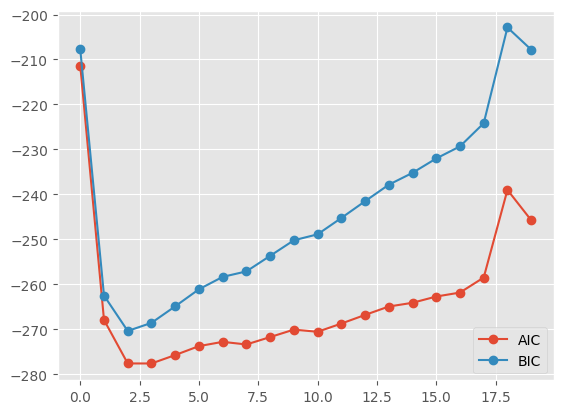

In [72]:
# plotting AIC and BIC values 
plt.plot(order_df.p, order_df.aic, marker='o', label='AIC')
plt.plot(order_df.p, order_df.bic, marker='o', label='BIC')
plt.legend()
plt.show()

The AIC and BIC are both the least for p = 2.

# Forecasting

### Splitting the data into training and testing

In [75]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

In [94]:
train

,deposit
year,
1980-01-01,0.0825
1981-01-01,0.1200
1982-01-01,0.1200
1983-01-01,0.1200
1984-01-01,0.1200
1985-01-01,0.1200
1986-01-01,0.1200
1987-01-01,0.1200
1988-01-01,0.1200


## In-sample Forecast

In [95]:
model = ARIMA(train.deposit, order=(2,0,0))
results = model.fit()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [96]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                deposit   No. Observations:                   36
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 114.048
Date:                Sat, 10 May 2025   AIC                           -220.096
Time:                        12:54:08   BIC                           -213.761
Sample:                    01-01-1980   HQIC                          -217.885
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0931      0.008     11.098      0.000       0.077       0.110
ar.L1          1.2563      0.132      9.490      0.000       0.997       1.516
ar.L2         -0.5287      0.140     -3.779      0.0

In [162]:
forecast_in = results.get_prediction(start=36, end=44, dynamic=False)
mean_forecast_in = forecast_in.predicted_mean
confidence_int_in = forecast_in.conf_int()
lower_limits_in = confidence_int_in['lower deposit']
upper_limits_in = confidence_int_in['upper deposit']

In [165]:
mean_forecast_in

2016-01-01    0.080368
2017-01-01    0.082971
2018-01-01    0.087104
2019-01-01    0.090920
2020-01-01    0.093529
2021-01-01    0.094788
2022-01-01    0.094992
2023-01-01    0.094581
2024-01-01    0.093958
Freq: YS-JAN, Name: predicted_mean, dtype: float64

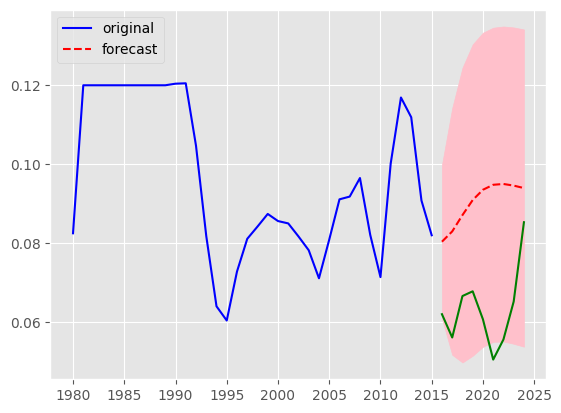

In [167]:
plt.figure()
plt.plot(train.index, train.deposit, label='original', color='blue')
# Plot prediction
plt.plot(test.index,
mean_forecast_in.values,
color='red', linestyle='--',
label='forecast')
plt.plot(test.index, test['deposit'], color='green')
# Shade uncertainty area
plt.fill_between(test.index, lower_limits_in, upper_limits_in, color='pink')
plt.legend()
plt.show()

### Out of sample forecast

In [172]:
forecast_out = results.get_forecast(steps=20)
# forecast mean
mean_forecast_out = forecast_out.predicted_mean
# Get confidence intervals of forecasts
confidence_int_out = forecast_out.conf_int()
lower_limits_out = confidence_int_out['lower deposit']
upper_limits_out = confidence_int_out['upper deposit']

ValueError: 'x' has size 9, but 'y1' has an unequal size of 20

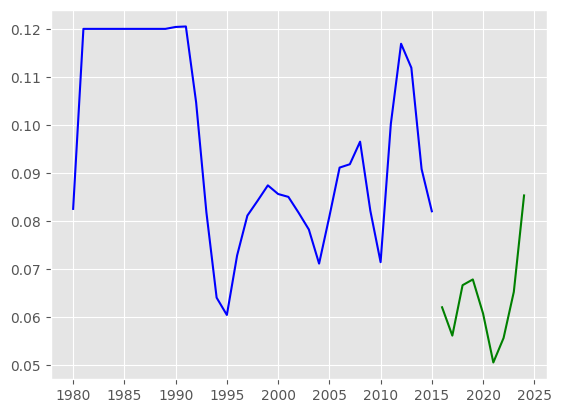

In [ ]:
plt.figure()
plt.plot(train.index, train.deposit, label='original', color='blue')
# Plot prediction
# plt.plot(forecast.index, mean_forecast.values, color='red', linestyle='--', label='forecast')
plt.plot(test.index, test['deposit'], color='green')
# Shade uncertainty area
# plt.fill_between(test.index, lower_limits_out, upper_limits_out, color='pink')
plt.legend()
plt.show()

d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
d:\Internship\Analysis\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)



Out-of-sample RMSE: 0.0290
In-sample RMSE: 0.0095


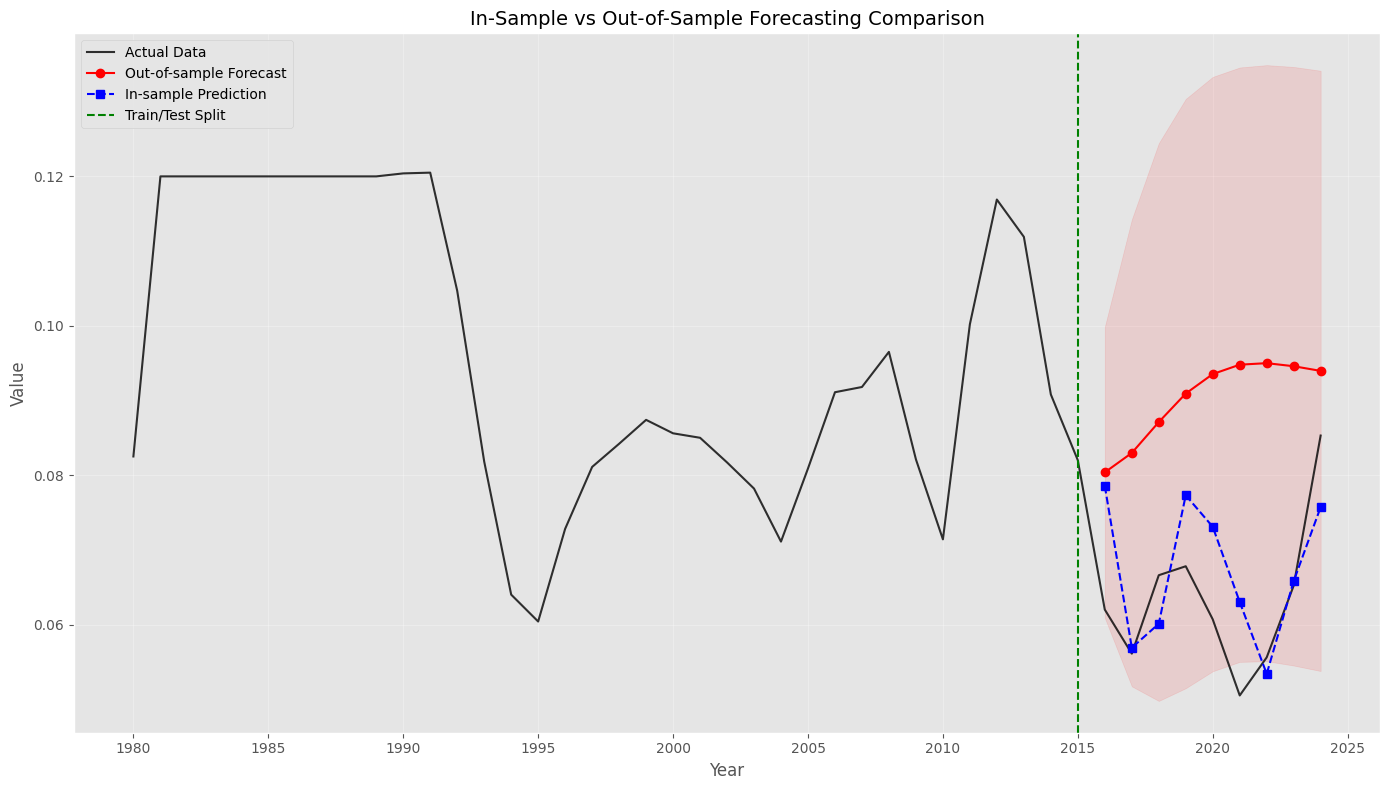

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [194]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split data (36 train, 9 test)
train = data.iloc[:36]
test = data.iloc[36:]

## 2. Out-of-Sample Forecasting
# Fit model on training data only
model_oos = ARIMA(train.deposit, order=(2,0,0))  # Adjust order as needed
model_oos_fit = model_oos.fit()

# Forecast the test period (9 steps ahead)
forecast_oos = model_oos_fit.get_forecast(steps=len(test))
forecast_oos_mean = forecast_oos.predicted_mean
forecast_oos_ci = forecast_oos.conf_int()

## 3. In-Sample Fitting
# Fit model on complete dataset (train + test)
model_ins = ARIMA(data.deposit, order=(2,0,0))  # Same order as out-of-sample
model_ins_fit = model_ins.fit()

# Get in-sample predictions for entire series
predictions_ins = model_ins_fit.get_prediction()
predictions_ins_mean = predictions_ins.predicted_mean
predictions_ins_ci = predictions_ins.conf_int()

## 4. Calculate RMSE
# Out-of-sample RMSE (test period only)
rmse_oos = np.sqrt(mean_squared_error(test.deposit, forecast_oos_mean))

# In-sample RMSE (test period only)
ins_test_pred = predictions_ins_mean[test.index]
rmse_ins = np.sqrt(mean_squared_error(test.deposit, ins_test_pred))

print(f"\nOut-of-sample RMSE: {rmse_oos:.4f}")
print(f"In-sample RMSE: {rmse_ins:.4f}")

## 5. Plotting Results
plt.figure(figsize=(14, 8))

# Plot complete series
plt.plot(data.deposit, label='Actual Data', color='black', alpha=0.8)

# Plot out-of-sample forecast
plt.plot(forecast_oos_mean.index, forecast_oos_mean, 
         'ro-', label='Out-of-sample Forecast')
plt.fill_between(forecast_oos_mean.index,
                forecast_oos_ci.iloc[:,0],
                forecast_oos_ci.iloc[:,1],
                color='red', alpha=0.1)

# Plot in-sample predictions (test period only)
plt.plot(ins_test_pred.index, ins_test_pred,
         'bs--', label='In-sample Prediction')
# plt.fill_between(ins_test_pred.index,
#                 predictions_ins_ci.loc[test.index, 'lower y'],
#                 predictions_ins_ci.loc[test.index, 'upper y'],
#                 color='blue', alpha=0.1)

# Add vertical line for train/test split
plt.axvline(x=train.index[-1], color='green', linestyle='--', 
           label='Train/Test Split')

# Formatting
plt.title('In-Sample vs Out-of-Sample Forecasting Comparison', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Additional Comparison Plot (Test Period Only)
plt.figure(figsize=(14, 6))

# Plot test data
# plt.plot(test, 'ko-', label='Actual Test Data')

# Plot out-of-sample forecast
# plt.plot(forecast_oos_mean, 'ro-', label='Out-of-sample Forecast')
# plt.fill_between(forecast_oos_mean.index,
#                 forecast_oos_ci.iloc[:,0],
#                 forecast_oos_ci.iloc[:,1],
#                 color='red', alpha=0.1)

# # Plot in-sample predictions
# plt.plot(ins_test_pred, 'bs--', label='In-sample Prediction')
# plt.fill_between(ins_test_pred.index,
#                 predictions_ins_ci.loc[test.index, 'lower y'],
#                 predictions_ins_ci.loc[test.index, 'upper y'],
#                 color='blue', alpha=0.1)

# plt.title('Test Period Comparison', fontsize=14)
# plt.xlabel('Year')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()